/var/folders/rl/0fstgkgs7t93dk9q8yhnw9lc0000gs/T/ipykernel_95170/4001184953.py:139: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rl/0fstgkgs7t93dk9q8yhnw9lc0000gs/T/ipykernel_95170/4001184953.py:139: UserWarning: Glyph 38544 (\N{CJK UNIFIED IDEOGRAPH-9690}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rl/0fstgkgs7t93dk9q8yhnw9lc0000gs/T/ipykernel_95170/4001184953.py:139: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH-5F0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rl/0fstgkgs7t93dk9q8yhnw9lc0000gs/T/ipykernel_95170/4001184953.py:139: UserWarning: Glyph 29275 (\N{CJK UNIFIED IDEOGRAPH-725B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rl/0fstgkgs7t93dk9q8yhnw9lc0000gs/T/ipykernel_95170/4001184953.py:139: UserWarning: Glyph 39039 (\N{CJK UNIFIED IDEOGRAPH-987F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rl

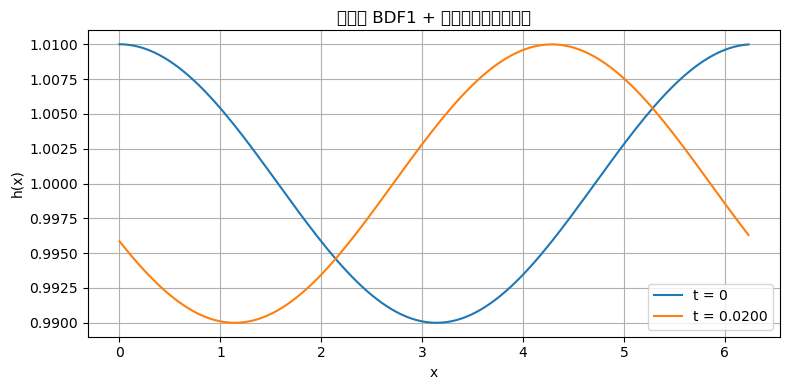

In [8]:
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as spla

# ----------------------------
# 1. 参数设置
# ----------------------------
L = 2 * np.pi         # 周期长度
N = 128               # 空间网格点数（可根据资源调整）
dx = L / N
x = np.linspace(0, L, N, endpoint=False)

# 傅里叶频率与波数
k = np.fft.fftfreq(N, d=dx) * 2 * np.pi
ik = 1j * k

# 时间步与总步数
dt = 5e-6             # 若用后向欧拉，dt 可稍大一些，但还是受非线性限制
t_final = 0.02
num_steps = int(t_final / dt)

# 牛顿迭代参数
newton_tol = 1e-8     # 牛顿残差收敛阈值
newton_maxit = 20     # 最大牛顿迭代次数

# 2. 定义 非线性算子 F(h) 以及它对应的伪谱实现
def compute_F(h):
    """
    计算 F(h) = -∂^2_x [ h^3 * ∂^5_x h ] ，
    返回一个长度为 N 的向量。
    """
    # FFT → 拿到 h_hat
    h_hat = np.fft.fft(h)

    # 五阶导数：IFFT( (i k)^5 * h_hat )
    d5h = np.fft.ifft((ik**5) * h_hat).real

    # 非线性乘积 h^3 * d5h
    product = 100*h**3 * d5h

    # 再傅里叶变换
    prod_hat = np.fft.fft(product)

    # 二阶导数：IFFT( (i k)^2 * prod_hat )
    lap2 = np.fft.ifft((ik**2) * prod_hat).real

    return -lap2


# 3. 定义残差函数 R(h_new; h_old) 及其雅可比
def residual(h_new, h_old):
    """
    计算 R(h_new) = h_new - h_old - dt * F(h_new) ，返回 N 维向量。
    """
    return h_new - h_old - dt * compute_F(h_new)


def build_jacobian_dense(h_new):
    """
    构造雅可比矩阵 J = dR/dh  = I - dt * dF/dh  (密集矩阵版)。
    这一步是最“直接”但最耗 RAM 的：要对每个自由度微扰一遍来近似行导数。
    返回一个 N×N 的 numpy.ndarray。
    """
    eps = 1e-6
    J = np.zeros((N, N), dtype=np.float64)

    # 先把 compute_F(h_new) 计算一遍，避免重复 FFT
    F0 = compute_F(h_new)

    # 中心差分近似：对每个分量 i 做微扰
    for i in range(N):
        # 构造一个单位扰动 v，使得 (h_new + eps*v)
        v = np.zeros(N)
        v[i] = eps

        F_perturbed = compute_F(h_new + v)
        # 数值导数： (F(h+v) - F(h)) / eps
        dF_dhi = (F_perturbed - F0) / eps

        # J 的第 i 列 = ∂R/∂h_i = e_i - dt * ∂F/∂h_i
        # 注意：R = h_new - h_old - dt*F(h_new)，对 h_new 求导时，
        # ∂(h_new)/∂h_i → 第 i 列是单位向量；∂(-dt*F)/∂h_i → -dt * dF_dhi
        J[:, i] = 0.0
        J[i, i] += 1.0            # 来自 h_new 项的 ∂h_new/∂h_i
        J[:, i] += -dt * dF_dhi   # 来自 -dt*F(h_new) 项
    return J


# 4. 主循环：时间推进
#    用向后欧拉（BDF1），每一步配合牛顿迭代解非线性系统
# ----------------------------
h = 1.0 + 0.01*np.cos(x)   # 初始条件
for n in range(num_steps):
    h_old = h.copy()
    h_new = h_old.copy()    # 牛顿初始猜测取上一步解

    # ———— 牛顿迭代求解 h_new ————
    for it in range(newton_maxit):
        # 1) 计算残差
        R = residual(h_new, h_old)

        # 检查残差是否足够小
        res_norm = la.norm(R, np.inf)
        if res_norm < newton_tol:
            # 已经收敛
            break

        # 2) 构造雅可比矩阵（密集版）
        J = build_jacobian_dense(h_new)

        # 3) 线性求解： J · δh = R  → δh = J^{-1} R
        #    注意：此处直接用稠密求逆或解线性方程组即可。对于 N≥256 时会很慢。
        δh = la.solve(J, R)

        # 4) 更新
        h_new -= δh

        # 若 δh 足够小，也可提早退出
        if la.norm(δh, np.inf) < 1e-9:
            break

    else:
        # 如果牛顿在 maxit 内没收敛，可给个警告
        print(f"[Warning] 第 {n} 步，牛顿迭代未收敛，残差 {res_norm:e}")

    # 本步结束，把收敛的结果赋给 h
    h = h_new.copy()

# 5. 最终绘图或后处理
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(x, 1 + 0.01*np.cos(x), label='t = 0')
plt.plot(x, h, label=f't = {t_final:.4f}')
plt.xlabel('x')
plt.ylabel('h(x)')
plt.title('全隐式 BDF1 + 牛顿求解后数值剖面')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
